In [2]:
%load_ext autoreload

%autoreload 2
import GCRCatalogs
import matplotlib.pyplot as plt
import pickle
import sys
from astropy.table import QTable, Table, vstack, join 
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

#module from my personnal github
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Mass_richness_relation as mr

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
down, up, n_bins = 0.1, 15, 40
bin_edges = make_bins(down, up, nbins=n_bins, method='evenlog10width')
radial_bin = binning(bin_edges)

In [4]:
radial_bin_mid = np.mean(radial_bin, axis = 1)

In [5]:
radial_bin_mid

array([ 0.10667249,  0.12090791,  0.13704304,  0.15533141,  0.17606035,
        0.19955556,  0.22618621,  0.25637071,  0.29058332,  0.3293616 ,
        0.37331483,  0.42313361,  0.4796007 ,  0.5436033 ,  0.61614704,
        0.69837173,  0.79156928,  0.89720402,  1.0169357 ,  1.15264555,
        1.30646584,  1.48081341,  1.67842763,  1.90241343,  2.15629007,
        2.4440465 ,  2.77020396,  3.13988707,  3.5589043 ,  4.03383928,
        4.57215424,  5.1823072 ,  5.87388494,  6.65775358,  7.54622931,
        8.55327193,  9.69470417, 10.98846028, 12.45486786, 14.1169672 ])

In [6]:

def load(filename, **kwargs):

    with open(filename, 'rb') as fin:
        
        return pickle.load(fin, **kwargs)

In [7]:
profile_true = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/cosmoDC2/cosmodc2_true_shape_all_bins_ns.pkl')
profile_epsilon = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/cosmoDC2/cosmodc2_epsilon_shape_all_bins_ns.pkl')

In [8]:
while 1 > 0:
    try:
        profile_SkySim5000 = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/SkySim5000/SkySim5000_epsilon_shape_all_bins_ns.pkl')
        break
    except: a = 1

In [9]:
len(profile_SkySim5000)

4725

In [10]:
z_corner = np.linspace(0.2, 1 , 9)
Z_bin = binning(z_corner)
m_corner = np.logspace(14, 15, 2)
#m_corner = np.linspace(1e14, 1e15, 7)
Mass_bin = binning(m_corner)
print(Z_bin), print(np.log10(Mass_bin))

[[0.2, 0.30000000000000004], [0.30000000000000004, 0.4], [0.4, 0.5], [0.5, 0.6000000000000001], [0.6000000000000001, 0.7], [0.7, 0.8], [0.8, 0.9000000000000001], [0.9000000000000001, 1.0]]
[[14. 15.]]


(None, None)

In [11]:
profile_stack_true = prf.stacked_profile(profile = profile_epsilon,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_stack_true = prf.sample_covariance(profile = profile_epsilon,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'M200c',
                #n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [12]:
profile_stack_true_sky = prf.stacked_profile(profile = profile_SkySim5000,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_stack_true_sky = prf.sample_covariance(profile = profile_SkySim5000,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'M200c',
                #n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_DATAOPS_make_profile.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return gt_w/w, gx_w/w, r_w/w
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_DATAOPS_make_profile.py:35: RuntimeWarning: invalid value encountered in true_divide
  return gt_w/w, gx_w/w, r_w/w


In [13]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
conc = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)

In [14]:
def modele_ds(r, logm, c, cluster_z):
    m = 10.**logm 
    moo.set_mass(m), moo.set_concentration(c)
    deltasigma = [] 
    for i, xr in enumerate(r):
        deltasigma.append(moo.eval_excess_surface_density(xr, cluster_z))
    return np.array(deltasigma)

In [15]:
def sig(r, z, r00, r0c):
    r0 = r00 
    rc = r0c 
    res = []
    for R in r: res.append((1./(1 + np.exp(-(R-r0)/rc))))
    return np.array(res)

In [16]:
def fit_sigmoid(profile = 1, cov = 1, fix_logm = True):
    
    r0, rc = [], []
    r0_err, rc_err = [], []
    logm_obs = []

    for i, p in enumerate(profile):

        def chi2(logm, r00, rc0):

            chi = 0
            
            if fix_logm == True: logm = np.log10(p['obs_mean'])
            cluster_z, R, y_exp, cov_t =  p['z_mean'], np.array(p['radius']), p['gt'], cov[i]['cov_t'].T.diagonal()
            sigmoid = sig(np.array(R, dtype = float), cluster_z, r00, rc0)
            y_predict = modele_ds(R, logm, conc._concentration(cosmo_ccl, 10**logm, 1/(1 + cluster_z)), cluster_z)
            data_vector = ((y_predict*sigmoid - y_exp)/np.sqrt(cov_t[0]))[(R < 5.5)]
            d = data_vector
            return np.sum((d)**2)

        minuit = Minuit(chi2, logm = 14, r00 = 0.5, rc0 = 0.5, fix_logm = fix_logm,
                    limit_logm = (11, 16),
                    limit_rc0 = (0., 1),
                    limit_r00 = (0., 1),
        
                   errordef = 1)

        minuit.migrad(),minuit.hesse(),minuit.minos()
        r0.append(minuit.values['r00'])
        rc.append(minuit.values['rc0'])
        r0_err.append(minuit.errors['r00'])
        rc_err.append(minuit.errors['rc0'])
        logm_obs.append(np.log10(p['obs_mean']))

    r0 = np.array(r0)
    r0_err = np.array(r0_err)
    rc = np.array(rc)
    rc_err = np.array(rc_err)
    return r0, r0_err, rc, rc_err, logm_obs

In [17]:
r0, r0_err, rc, rc_err, logm_obs = fit_sigmoid(profile = profile_stack_true, cov = covariance_stack_true, fix_logm = True)

In [18]:
r0sky, r0_errsky, rcsky, rc_errsky, logm_obs = fit_sigmoid(profile = profile_stack_true_sky, cov = covariance_stack_true_sky, fix_logm = True)

In [19]:
def fit(profile, r0, r0_err, rc, rc_err):
    
    def chi2(a, b):
        z = profile['z_mean']
        yexp = r0 + 6*rc
        yexp_err = np.sqrt(r0_err**2 + 36*rc_err**2)
        model = a * z  + b
        return np.sum(((yexp - model)/yexp_err)**2)

    minuit = Minuit(chi2, a = 1, b = 0, errordef = 1)
    minuit.migrad(),minuit.hesse(),minuit.minos()
    print(minuit.fval/(len(r0)-2))
    return minuit

In [20]:
minuit_sky = fit(profile_stack_true_sky, r0sky, r0_errsky, rcsky, rc_errsky)
minuit = fit(profile_stack_true, r0, r0_err, rc, rc_err)

0.6961166689972421
0.3618429091818553


In [21]:
minuit_sky.params, minuit.params

(┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   2.01    │   0.21    │   -0.21    │    0.21    │         │         │       │
│ 1 │ b    │   -0.10   │   0.08    │   -0.08    │    0.08    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘,
 ┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.53    │   0.25    │   -0.25    │    0.25    │         │         │       │
│ 1 │ b    │   0.38    │   0.10    │   -0.10    │    0.10    │         │         │     

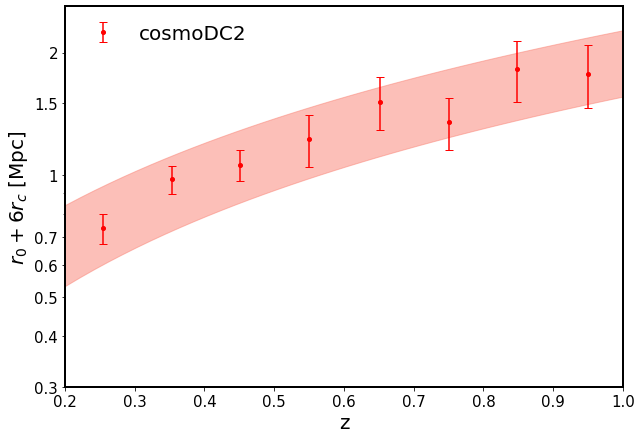

In [23]:
plt.figure(figsize = (10,7))
plt.rcParams['axes.linewidth']=2
d = cosmo.eval_da(profile_stack_true['z_mean'])
z = np.linspace(0,2, 100)
factor = 1
sigma = 1

plt.errorbar(profile_stack_true['z_mean'], (r0 + 6*rc)/factor, np.sqrt(r0_err**2 + 36*rc_err**2)/factor , fmt = ' ', capsize = 4, color = 'r', marker = 'o', markersize = 4, zorder = 100, label = 'cosmoDC2')
y = (( minuit.values['a']) * profile_stack_true['z_mean'] + ( minuit.values['b'] ))/factor
y_up =(( minuit.values['a'] + sigma* minuit.errors['a']) * z + ( minuit.values['b'] + sigma* minuit.errors['b']))/factor
y_down =(( minuit.values['a'] - sigma* minuit.errors['a']) * z + ( minuit.values['b'] - sigma* minuit.errors['b']))/factor
plt.fill_between(z,y_up, y_down, color = 'salmon', alpha = 0.5, zorder = 0)

plt.xlabel('z', fontsize = 20)
plt.ylim(0.5,2.6)
plt.yscale('log')
plt.xlim(0.2, 1)
plt.ylabel(r'$r_0 + 6r_c$ [Mpc]', fontsize = 20)
ticks = [0.3,0.4,0.5,0.6, 0.7, 1, 1.5, 2]
ticks_str = [str(t) for t in ticks]
plt.yticks(ticks=ticks, labels=ticks_str)
plt.tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
plt.legend(loc='upper left', frameon = False, fontsize = 20, numpoints = 1)
    #plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/sigmoid_cosmoDC2_SkySim.png', bbox_inches='tight', dpi=300)